### Objective
In order to tackle difficult problems (of large size and complexity), we introduce an deep Q learning.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.models import Model, load_model
import gym
from time import time,sleep
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
from rl_introduction.tools import Agent, DeepAgent, plot_values_lake, policy_improvement, discount_cumsum, run_experiment_episode_train
sns.set_style("darkgrid")

/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:

In [2]:
env = gym.make('CartPole-v0')

/home/raphael/rl_test/venv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
time_steps = 100
state = env.reset()
for _ in range(time_steps):
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)
    env.render()
    sleep(0.04)
env.close()

# deep Q-learning

When the state spaces is continous. It is necessary to have a function for the Q value. A common way to represent and update this function, it is to use parametric function (as neural network).
In other words, we are looking for $\theta \in \mathbb{R}^d$ such as 
$\forall s Q_\theta(s,a) = \mathbb{E}_\pi[G_t | S_t = s, A_t = a]$. We follow the same idea as q-learning:
we eant to update $Q_\theta(S_t,A_t)$ using the target $R_{t+1}+\gamma \max_a Q(S_{t+1},a)$. A natural loss is the mean square error:

$L(\theta) = \mathbb{E}_{s,a\sim Q} [(y_t - Q(s,a,\theta))^2]$



$y = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$

We have 2 ways to write our function:
1. $Q_\theta : S\times A \rightarrow \mathbb{R}$

in this case greedy policy looks like $\pi(.|s) = \arg\max([Q_\theta(s,a_0), Q_\theta(s,a_1),... Q_\theta(s,a_{dim(A)}]) $

The target is $y = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$
2. $Q_\theta : S \rightarrow \mathbb{R}^{dim(A)}$

in this case greedy policy looks like $\pi(.|s) = \arg\max(Q_\theta(s))$

The target is $y_i = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$ for i corresponding to the played action, $Q_\theta(s_t)_i$ otherwise.

In [3]:
def build_model(state_sim, action_dim):
    input_state = Input(name='input_state', shape=(state_dim,), dtype='float32')
    x = Dense(32, activation='relu')(input_state)
    x = Dense(32, activation='relu')(x)
    x = Dense(action_dim, activation='linear')(x)
    model = Model(inputs=input_state, outputs=x)
    model.compile(loss='mse',optimizer=Adam(learning_rate=1e-2))
    return model

In [4]:
#TODO: write deep Q learning update
class DeepQAgent(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .1):
        super().__init__(env, gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.env.action_space.n)
        else:
            predicted_Qs = self.model.predict(state.reshape(1, -1))[0]
            return np.argmax(predicted_Qs) 
    
    def train(self, current_state, action, reward, next_state, done):
        pass #complete here

In [ ]:
#Done: write deep Q learning update
class DeepQAgent(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .1):
        super().__init__(env, gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.env.action_space.n)
        else:
            predicted_Qs = self.model.predict(state.reshape(1, -1))[0]
            return np.argmax(predicted_Qs) 
    
    def train(self, current_state, action, reward, next_state, done):
        predicted_Q_nexts = self.model.predict(next_state.reshape(1, -1))[0]
        target = self.model.predict(current_state.reshape(1, -1))[0]
        if done is True:
            target[action] = reward
        else:
            target[action] = reward + self.gamma * np.max(predicted_Q_nexts)
        self.model.train_on_batch(current_state.reshape(1, -1), target.reshape(1, -1))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 8.0
episode: 1 - cum reward 13.0
episode: 2 - cum reward 9.0
episode: 3 - cum reward 9.0
episode: 4 - cum reward 9.

episode: 229 - cum reward 39.0
episode: 230 - cum reward 40.0
episode: 231 - cum reward 33.0
episode: 232 - cum reward 55.0
episode: 233 - cum reward 26.0
episode: 234 - cum reward 37.0
episode: 235 - cum reward 53.0
episode: 236 - cum reward 42.0
episode: 237 - cum reward 45.0
episode: 238 - cum reward 51.0
episode: 239 - cum reward 42.0
episode: 240 - cum reward 54.0
episode: 241 - cum reward 51.0
episode: 242 - cum reward 44.0
episode: 243 - cum reward 53.0
episode: 244 - cum reward 55.0
episode: 245 - cum reward 56.0
episode: 246 - cum reward 50.0
episode: 247 - cum reward 56.0
episode: 248 - cum reward 64.0
episode: 249 - cum reward 57.0
episode: 250 - cum reward 73.0
episode: 251 - cum reward 139.0
episode: 252 - cum reward 26.0
episode: 253 - cum reward 162.0
episode: 254 - cum reward 12.0
episode: 255 - cum reward 15.0
episode: 256 - cum reward 12.0
episode: 257 - cum reward 16.0
episode: 258 - cum reward 19.0
episode: 259 - cum reward 27.0
episode: 260 - cum reward 62.0
episod

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

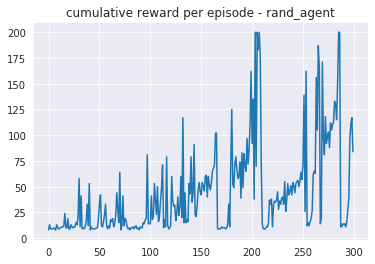

In [5]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = build_model(state_dim, action_dim)
q_agent = DeepQAgent(env, model)
rewards = run_experiment_episode_train(env, q_agent, 300)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

### Experience replay

$L_i(\theta_i) = \mathbb{E}_{(s, a, r, s') \sim U(D)} \left[ \left(r + \gamma \max_{a'} Q(s', a'; \theta_i^-) - Q(s, a; \theta_i)\right)^2 \right]$

In [6]:
#TODO: write The function replay that return bacth from memory
class DeepQAgent_experience_replay(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .1, memory_size = 2000, batch_size = 100):
        super().__init__(env, gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
        
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        
    def replay(self, batch_size):
        pass #complete here
    
        
    def act(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.env.action_space.n)
            return action
        predicted_Qs = self.model.predict(state.reshape(1, -1))[0]
        action = np.argmax(predicted_Qs) 
        return action
    
    def train(self, current_state, action, reward, next_state, done):
        self.memory.append([current_state, action, reward, next_state, done])
        x_batch, y_batch = self.replay(self.batch_size)
        loss = self.model.train_on_batch(x_batch, y_batch)

In [ ]:
#Done: write The function replay that return bacth from memory
class DeepQAgent_experience_replay(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .1, memory_size = 2000, batch_size = 100):
        super().__init__(env, gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
        
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
    
    # easy loop way
    #def replay(self, batch_size):
    #    x_batch =  np.zeros((batch_size, self.state_size))
    #    y_batch =  np.zeros((batch_size, self.action_size))
    #    minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
    #    for i, (state, action, reward, next_state, done) in enumerate(minibatch):
    #        target = self.model.predict(state.reshape(1,-1))[0]
    #        if done:
    #            target[action] = reward
    #        else:
    #            target[action] = reward + self.gamma * np.max(self.model.predict(next_state.reshape(1,-1)))
    #        x_batch[i] = state
    #        y_batch[i] = target
    #    return x_batch, y_batch
    
    #optimize way
    def replay(self, batch_size):
        minibatch = np.array(random.sample(self.memory, min(len(self.memory), batch_size)))
        states = np.vstack(np.array(minibatch)[:,0])
        actions = np.array(minibatch)[:,1].astype(int)
        rewards = np.array(minibatch)[:,2]
        next_states = np.vstack(np.array(minibatch)[:,3])
        dones = np.array(minibatch)[:,4]
        targets = self.model.predict(states)
        targets_next = self.model.predict(next_states)
        targets[np.arange(actions.size),actions] = rewards + (1 - dones) * self.gamma * np.max(targets_next, axis=1)
        return states, targets
    
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.env.action_space.n)
            return action
        predicted_Qs = self.model.predict(state.reshape(1, -1))[0]
        action = np.argmax(predicted_Qs) 
        return action
    
    def train(self, current_state, action, reward, next_state, done):
        self.memory.append([current_state, action, reward, next_state, done])
        x_batch, y_batch = self.replay(self.batch_size)
        loss = self.model.train_on_batch(x_batch, y_batch)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 9.0
episode: 1 - cum reward 9.0
episode: 2 - cum reward 9.0
episode: 3 - cum reward 10.0
episode: 4 - cum reward 11.0
episode: 5 - cum reward 13.0
episode: 6 - cum reward 22.0
episode: 7 - cum reward 36.0
episode: 8 - cum reward 16

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

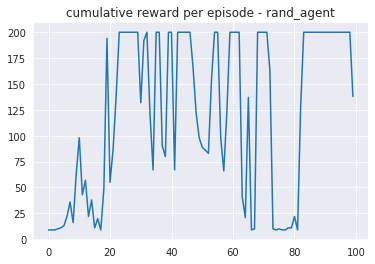

In [7]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = build_model(state_dim, action_dim)

q_agent = DeepQAgent_experience_replay(env, model)
rewards = run_experiment_episode_train(env, q_agent, 100)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

# Other improvments TODO extend

### clipping
$Q(s,a):=Q(s,a)+\alpha(clip(r+\gamma \arg\max(Q(s',a'))-Q(s,a), -1, 1))$

cf tf.keras.losses.Huber(delta=10000.)

### Double Q learning

DQN: A reinforcement learning algorithm that combines Q-Learning with deep neural networks to let RL work for complex, high-dimensional environments, like video games, or robotics.
Double Q Learning: Corrects the stock DQN algorithm’s tendency to sometimes overestimate the values tied to specific actions.
Prioritized Replay: Extends DQN’s experience replay function by learning to replay memories where the real reward significantly diverges from the expected reward, letting the agent adjust itself in response to developing incorrect assumptions.
Dueling DQN: Splits the neural network into two — one learns to provide an estimate of the value at every timestep, and the other calculates potential advantages of each action, and the two are combined for a single action-advantage Q function.